
# To run this notebook 

1.Create a directory (such as /home/username/mozi/jupyter in the below example) and put the notebook in it.

2.Put needed the needed data files into the directory, extracting from embeddings.tgz in this repository:

opencog_deps,mosesDoseNoFeature2Gene.csv,scV1kg26noDose.csv

3.Extract the following files from the mozi data site, and place them in the directory as well. The exact dates could change:

https://mozi.ai/datasets/gene-level-dataset_2020-04-03.tar.gz :

GO_2020-04-01.scm, GO_annotation_gene-level_2020-04-01.scm ,Go-Plus_2020-04-01.scm,NCBI2Reactome_PE_Pathway.txt_2020-04-01.scm,reactome_2020-04-01.scm,smpdb_gene_2020-04-03.scm 

https://mozi.ai/datasets/string_dataset_2020-04-01.tar.gz :

string_ggi_2020-03-31.scm

4.Call the command (replacing the directory with yours) :

docker run -p 8888:8888 -v /home/username/mozi/jupyter:/home/opencog -e mem_size=30000000000  xabush/opencog-jupyter:moses


In [1]:
import sys
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install graphviz

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%cd /home/opencog/

/home/opencog


In [3]:
from opencog.atomspace import AtomSpace, types
from opencog.scheme_wrapper import scheme_eval
from opencog.type_constructors import *
from opencog.atomspace import get_refreshed_types, get_type, get_type_name

In [4]:
atomspace = AtomSpace()

In [5]:
#deps= "/home/opencog/opencog_deps"
#sample_dataset = "/opt/sample_dataset.scm"
#deps= "opencog_deps"
#sample_dataset = "sample_dataset.scm"

#load the opencog_deps file which has the modules necessary to make the pattern matching functions run
#scheme_eval(atomspace, '(primitive-load "{}")'.format(deps))

# JJJ
scheme_eval(atomspace, "(use-modules (ice-9 readline))")
scheme_eval(atomspace, "(activate-readline)")
scheme_eval(atomspace, "(debug-enable 'backtrace)")
scheme_eval(atomspace, "(read-enable 'positions)")
scheme_eval(atomspace, "(use-modules (opencog))")
scheme_eval(atomspace, "(use-modules (opencog exec))")
scheme_eval(atomspace, "(use-modules (opencog bioscience))")
scheme_eval(atomspace, "(use-modules (rnrs base))")
scheme_eval(atomspace, "(use-modules (rnrs exceptions))")
scheme_eval(atomspace, "(use-modules (ice-9 textual-ports))")
scheme_eval(atomspace, "(use-modules (ice-9 regex))")
scheme_eval(atomspace, "(use-modules (srfi srfi-98))")
scheme_eval(atomspace, "(use-modules (ice-9 match))")
scheme_eval(atomspace, "(use-modules (ice-9 threads))")
scheme_eval(atomspace, "(use-modules (ice-9 ftw))")
scheme_eval(atomspace, "(use-modules (srfi srfi-1))")

b'\n'

In [6]:

scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/string_ggi_2020-03-31.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/GO_2020-04-01.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/Go-Plus-GO_2020-05-04.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/GO_annotation_gene-level_2020-04-01.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/NCBI2Reactome_PE_Pathway.txt_2020-04-01.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/reactome_2020-04-01.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/smpdb_gene_2020-04-03.scm"))


#verify the atoms are loaded

print("after datasets:" +scheme_eval(atomspace, "(count-all)").decode("utf-8"))

after datasets:3374137



In [7]:
#specify the default atomspace to use for running queries
set_default_atomspace(atomspace)

In [8]:
#we need to refresh the type dict so that it contains the newly added types [GeneNode, MoleculeNode]
types = get_refreshed_types()

In [9]:
import copy
def find_deepwalk_node_type(node): 
    deepwalk_node_type = None
    node_defs ={ 
            #take the first that begins with the string"
            "ConceptNode":[("R-HSA","rhsapathway"), ("SMP","smppathway"), ("GO:","geneontologyterm")],
            "PredicateNode":[("has_location","location")],
            "GeneNode":[("","gene")]
    }
    #print("node.type_name")
    #print(node.type_name)
    if (node.type_name in node_defs):
        prefix_list =copy.deepcopy(node_defs[node.type_name])
        found = False
        while not found and len(prefix_list)> 0:
            prefix_tuple = prefix_list.pop(0)
            #print ("prefix_tuple")
            #print (prefix_tuple)
            if prefix_tuple[0] == "" or node.name.startswith(prefix_tuple[0]):
                found == True
                deepwalk_node_type = prefix_tuple[1]
                
    return deepwalk_node_type

In [10]:
from opencog.bindlink import execute_atom

def construct_eval_set_query(predicate, node, other_type=None):
    '''
    Note: this function is returning the Evalutaion Links instead of the grounded node because 
    the links have the truth values
    '''
    if other_type is None:      
        bind_atom = \
            GetLink(
                VariableNode("$g"),
                EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                 EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                )
            )
    else:
        bind_atom = \
            BindLink(
                TypedVariableLink(VariableNode("$g"), TypeNode(other_type)),
                EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                )
            )
        
    result = execute_atom(atomspace, bind_atom)
    #print(result)
    return result.out

In [11]:
from opencog.bindlink import execute_atom

def construct_eval_query(predicate, node, other_type=None):
    if other_type is None:      
        bind_atom = \
            BindLink(
                VariableNode("$g"),
                EvaluationLink(
                    PredicateNode(predicate),
                    ListLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                VariableNode("$g")
            )
    else:
        bind_atom = \
            BindLink(
                TypedVariableLink(VariableNode("$g"), TypeNode(other_type)),
                EvaluationLink(
                    PredicateNode(predicate),
                    ListLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                VariableNode("$g")
            )
        
    result = execute_atom(atomspace, bind_atom)
    return result.out


In [12]:
from opencog.bindlink import execute_atom
def construct_member_query(node):
    member_atom = \
        BindLink(VariableNode("$g"),
                 MemberLink(
                    node,
                    VariableNode("$g")
                 ),
                 VariableNode("$g")
                 )
    
    result = execute_atom(atomspace, member_atom)
    return result.out

In [13]:
from opencog.bindlink import execute_atom
def construct_inheritance_query(node):
    member_atom = \
        BindLink(VariableNode("$g"),
                 InheritanceLink(
                    node,
                    VariableNode("$g")
                 ),
                 VariableNode("$g")
                 )
    
    result = execute_atom(atomspace, member_atom)
    return result.out

In [14]:
from opencog.bindlink import execute_atom
def construct_subset_query(node):
    member_atom = \
        BindLink(VariableNode("$g"),
                 SubsetLink(
                    node,
                    VariableNode("$g")
                 ),
                 VariableNode("$g")
                 )
    
    result = execute_atom(atomspace, member_atom)
    return result.out

In [15]:
def construct_context_query(gene):
    query_atom = \
        BindLink(
            VariableList(
                TypedVariableLink(VariableNode("$p"), TypeNode("ConceptNode")),
                TypedVariableLink(VariableNode("$q"), TypeNode("ConceptNode"))
            ),
    
            ContextLink(
                
                MemberLink (
                    gene,
                    VariableNode ("$p")
                ),

                EvaluationLink (
                     PredicateNode ("has_location"),
                     ListLink(
                        gene,
                        VariableNode ("$q")
                     )
                )

            ),
       
        
            ListLink(
                VariableNode("$p"),
                VariableNode("$q")
            )
        )
    result = execute_atom(atomspace, query_atom)
    return result.out

In [16]:
linkset = {"inhibits", "is-inhibited-by", "ptmod", "is-ptmoded-by", "expresses","is-expressed-by", 
           "activates", "is-activated-by", "catalyzes", "is-catalyzed-by", "binds-with", "reacts-with", 
            "in-smp-pathway", "has-smp-pathway-member", "in-gene-ontology",
           "has-gene-ontology-member", 'is-in',  'in-context-of', 'is-context-where', 
           'has', "inherits-pathway", "pathway-inherited-by", 
           "inherits-geneontologyterm", "geneontologyterm-inherited-by", "positively-regulates",
           "is-positively-regulated-by", "negatively-regulates", "is-negatively-regulated-by",
           'has-variant','is-variant-of',"has-person-member", "is-person-member-of", 
           "superc-has-variant", "is-variant-of-superc",
           "normal-has-variant", "is-variant-of-normal"
          }
geneset = set()
rhsapathwayset = set()
smppathwayset= set()
geneontologytermset = set()
locationset = set()

for node in atomspace.get_atoms_by_type(types.Node):
    deepwalk_type = find_deepwalk_node_type(node)
    
    if deepwalk_type and deepwalk_type =="gene":
        geneset.add(node.name)
    if deepwalk_type and deepwalk_type =="rhsapathway":
        rhsapathwayset.add(node.name)
    if deepwalk_type and deepwalk_type =="smppathway":
        smppathwayset.add(node.name)
    if deepwalk_type and deepwalk_type =="geneontologyterm":
        geneontologytermset.add(node.name)
    if deepwalk_type and deepwalk_type =="location":
        locationset.add(node.name)
genelist = list(geneset)
print(len(genelist))
geneontologytermlist =list(geneontologytermset)
len(geneontologytermlist)

28277


44559

In [17]:
import pandas as pd

biomapdf = pd.read_csv("csv/mosesDoseNoFeature2Gene.csv")
centdf = pd.read_csv("csv/scV1kg26noDose.csv")
print(len(biomapdf))

genes=set(biomapdf['Name'])
print(len (genes))

intersection = genes.intersection(geneset)
print(len(intersection))

current_map =biomapdf[biomapdf['Name'].isin(intersection)]
print(len(current_map))

51877
1843
934
37741


In [18]:
phrases =set()
truth_values ={}
halfphrases = set()
proteinset = set()
for index, row in current_map.iterrows():
    phrases.add((row['Name'].strip(),'has-variant',row['feature'].strip()))
    halfphrases.add((row['Name'].strip(),'has-variant',row['feature'].strip()))
    phrases.add((row['feature'].strip(),'is-variant-of',row['Name'].strip()))
    proteinset.add(row['feature'].strip())


In [19]:
supercpersonset =set()
normalpersonset = set()
persontypeset = set()
persontypeset.add('normal')
persontypeset.add('superc')
isa_supercenturian =[]
for (columnName, columnData) in centdf.iteritems():
    if columnName== 'case':
        isa_supercenturian = columnData.values
    else:
        for index,has_expressed in enumerate(columnData.values):
            name =""
            if isa_supercenturian[index]==1:
                name = "superc"+str(index)
                phrases.add(("superc","has-person-member",name))
                halfphrases.add(("superc","has-person-member",name))
                phrases.add((name, "is-person-member-of", "superc"))
                supercpersonset.add(name)
                if has_expressed == 1:
                    phrases.add((name,"superc-has-variant",columnName.strip()))
                    halfphrases.add((name,"superc-has-variant",columnName.strip()))
                    phrases.add((columnName.strip(), "is-variant-of-superc", name))
            else:
                name = "normal"+str(index)
                phrases.add(("normal","has-person-member",name))
                halfphrases.add(("normal","has-person-member",name))
                phrases.add((name, "is-person-member-of", "normal"))
                normalpersonset.add(name)
                if has_expressed == 1:
                    phrases.add((name,"normal-has-variant",columnName.strip()))
                    halfphrases.add((name,"normal-has-variant",columnName.strip()))
                    phrases.add((columnName.strip(), "is-variant-of-normal", name))
supercpersonlist = list(supercpersonset)

In [20]:
def add_gene_triplet(node,name,verb,reverse):
    result3 = construct_eval_set_query(name, node, other_type='GeneNode')
    if result3:
        for evalLink in result3:
            tv = None
            if hasattr(evalLink,"tv"):
                strength = evalLink.tv.mean
                confidence = evalLink.tv.confidence
                tv = (strength,confidence)
                #print(tv)
            node2 = evalLink.out[1].out[0]
            deepwalk_type2=find_deepwalk_node_type(node2)
            #print(deepwalk_type2)
            if deepwalk_type2 =="gene":
                tup = (node.name.strip() ,verb, node2.name.strip() )
                reverse_tup = (node2.name.strip() ,reverse, node.name.strip() )
                if (node2.name.strip(),node.name.strip()) not in existingTuples:
                    halfphrases.add(tup)
                    existingTuples.add((node.name.strip(),node2.name.strip()))
                phrases.add(tup)
                phrases.add(reverse_tup)
                if tv is not None:
                    truth_values [tup]=tv
                    truth_values[reverse_tup]=tv


In [21]:
existingTuples = set()

for node in atomspace.get_atoms_by_type(types.Node):
    #print('node.name')
    #print(node.name)
    deepwalk_type = find_deepwalk_node_type(node)
    if deepwalk_type and deepwalk_type =="gene":
        result = construct_member_query(node)
        if result:
            for node2 in result:
                deepwalk_type2=find_deepwalk_node_type(node2)
                if deepwalk_type2 =="smppathway":
                    halfphrases.add((node.name.strip() ,"in-smp-pathway", node2.name.strip() ))
                    phrases.add((node.name.strip() ,"in-smp-pathway", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"has-smp-pathway-member", node.name.strip() ))
                elif deepwalk_type2 =="geneontologyterm":
                    halfphrases.add((node.name.strip() ,"in-gene-ontology", node2.name.strip() ))
                    phrases.add((node.name.strip() ,"in-gene-ontology", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"has-gene-ontology-member", node.name.strip() ))
        result2 = construct_context_query(node)
        if result2:
            for node2 in result2:
                halfphrases.add((node.name.strip(), 'is-in', node2.out[1].name.strip(), 'in-context-of', node2.out[0].name.strip()))
                
                phrases.add((node.name.strip(), 'is-in', node2.out[1].name.strip(), 'in-context-of', node2.out[0].name.strip()))
                phrases.add(( node2.out[0].name.strip(), 'is-context-where', node2.out[1].name.strip(), 'has', node.name.strip()))
       
        #result3 = construct_eval_query('interacts_with', node, other_type='GeneNode')
        add_gene_triplet(node,'inhibition','inhibits','is-inhibited-by')
        add_gene_triplet(node,'ptmod','ptmod','is-ptmoded-by')
        add_gene_triplet(node,'expression','expresses','is-expressed-by')
        add_gene_triplet(node,'activation','activates','is-activated-by')
        add_gene_triplet(node,'catalysis','catalyzes','is-catalyzed-by')
        add_gene_triplet(node,'binding','binds-with','binds-with')
        add_gene_triplet(node,'reaction','reacts-with','reacts-with')
    
    elif deepwalk_type and deepwalk_type =="rhsapathway":
        result10 = construct_inheritance_query(node)
        if result10:
            for node2 in result10:
                deepwalk_type2=find_deepwalk_node_type(node2)
                if deepwalk_type2 =="rhsapathway":
                    halfphrases.add((node.name.strip() ,"inherits-pathway", node2.name.strip() ))
                    
                    phrases.add((node.name.strip() ,"inherits-pathway", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"pathway-inherited-by", node.name.strip() ))
    elif deepwalk_type and deepwalk_type =="geneontologyterm":
        result11 = construct_inheritance_query(node)
        if result11:
            for node2 in result11:
                deepwalk_type2=find_deepwalk_node_type(node2)
                if deepwalk_type2 =="geneontologyterm":
                    halfphrases.add((node.name.strip() ,"inherits-geneontologyterm", node2.name.strip() ))
                    
                    phrases.add((node.name.strip() ,"inherits-geneontologyterm", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"geneontologyterm-inherited-by", node.name.strip() ))
        result12 = construct_eval_query('GO_positively_regulates', node, other_type='ConceptNode')
        if result12:
            for node2 in result12:
                deepwalk_type2=find_deepwalk_node_type(node2)
                if deepwalk_type2 =="geneontologyterm":
                    halfphrases.add((node.name.strip() ,"positively-regulates", node2.name.strip() ))
                    
                    phrases.add((node.name.strip() ,"positively-regulates", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"is-positively-regulated-by", node.name.strip() ))
        result13 = construct_eval_query('GO_negatively_regulates', node, other_type='ConceptNode')
        if result13:
            for node2 in result13:
                deepwalk_type2=find_deepwalk_node_type(node2)
                if deepwalk_type2 =="geneontologyterm":
                    halfphrases.add((node.name.strip() ,"negatively-regulates", node2.name.strip() ))
                    
                    phrases.add((node.name.strip() ,"negatively-regulates", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"is-negatively-regulated-by", node.name.strip() ))

In [22]:
includedNodesSet = set()
includedRelationsSet=set()
includedTripletsSet= set()
for tup in halfphrases:
    if len(tup)> 1:
        includedNodesSet.add(tup[0])
        includedRelationsSet.add(tup[1])
        includedNodesSet.add(tup[2])
    if len(tup)> 3:
        includedRelationsSet.add(tup[3])
        includedNodesSet.add(tup[4])
    if len(tup)== 3:
        includedTripletsSet.add(tup)
    elif len(tup)==5:
        splittup = tuple([tup[0],tup[1],tup[2]])
        includedTripletsSet.add(splittup)
        splittup = tuple([tup[2],tup[3],tup[4]])
        includedTripletsSet.add(splittup)
        

In [23]:
percent_test=10
percent_valid=10
num_test = int(len(phrases) * 0.01 * percent_test)
num_valid_and_test = int(len(phrases) * 0.01 * percent_valid) + num_test

file = open("entities.dict","w") 
for i,node in enumerate(includedNodesSet):
    file.write("{0}\t{1}\n".format(i,node)) 
file.close() 
 
file = open("relations.dict","w") 
for i,rel in enumerate(includedRelationsSet):
    file.write("{0}\t{1}\n".format(i,rel)) 
file.close() 

file1 = open("test.txt","w") 
file2 = open("valid.txt","w") 
file3 = open("train.txt","w") 
for i,t in enumerate(includedTripletsSet):
    if i < num_test:
        file1.write("{0}\t{1}\t{2}\n".format(t[0],t[1],t[2])) 
    elif i < num_valid_and_test:
        file2.write("{0}\t{1}\t{2}\n".format(t[0],t[1],t[2])) 
    else:
        file3.write("{0}\t{1}\t{2}\n".format(t[0],t[1],t[2])) 
    
file1.close()
file2.close()    
file3.close() 

In [24]:
len(phrases)

6146220

In [25]:
phrases

{('normal51', 'normal-has-variant', '7:7775515_A/G'),
 ('X:70471067_C/G', 'is-variant-of-normal', 'normal480'),
 ('3:10045734_T/C', 'is-variant-of-normal', 'normal308'),
 ('normal245', 'normal-has-variant', '3:196388795_C/T'),
 ('normal173', 'normal-has-variant', '16:6069484_C/T'),
 ('R-HSA-5389840',
  'is-context-where',
  'mitochondrial inner membrane',
  'has',
  'MRPL23'),
 ('NDUS2', 'binds-with', 'NDUS8'),
 ('SF3B1', 'binds-with', 'DNJC8'),
 ('GO:0070672', 'inherits-geneontologyterm', 'GO:0034097'),
 ('normal253', 'normal-has-variant', 'X:107400055_C/A'),
 ('X:133679671_T/G', 'is-variant-of-normal', 'normal144'),
 ('X:130217834_G/A', 'is-variant-of-normal', 'normal521'),
 ('FGF23', 'binds-with', 'RET'),
 ('normal303', 'normal-has-variant', '12:101800809_G/A'),
 ('16:6069484_C/T', 'is-variant-of-normal', 'normal37'),
 ('PGS1', 'in-smp-pathway', 'SMP0045116'),
 ('DRD4', 'in-gene-ontology', 'GO:0007212'),
 ('normal356', 'normal-has-variant', '2:238989295_C/T'),
 ('11:43919411_A/G', '

In [26]:
phraselist = list(phrases)

In [27]:
#for p in phraselist:
    #print(p)

In [28]:
import pickle
try:
    with open("dict51.p", "rb") as f:
            normalized = pickle.load(f)
except Exception:
    dict1={}
    for tup in phrases:
        tv = truth_values[tup] if tup in truth_values else None
        if len(tup)>1:
            tup0 = tuple([tup[0]])
            if tup0 not in dict1:
                dict1[tup0]= set()
            dict1[tup0].add((("",tup[1]),1))
        if len(tup)>2:
            if (tup[0],tup[1]) not in dict1:
                dict1[(tup[0],tup[1])]= set()
            confidence = tv[1] if tv is not None else 1
            strength = "weakly" if tv is not None and tv[0]<0.25 else "moderately" if tv is not None and tv[0]<0.5 else ""
            dict1[(tup[0],tup[1])].add(((strength,tup[2]),confidence))
        if len(tup)>3:
            if (tup[0],tup[1],tup[2]) not in dict1:
                dict1[(tup[0],tup[1],tup[2])]= set()
            dict1[(tup[0],tup[1],tup[2])].add((("",tup[3]),1))
        if len(tup)>4:
            if (tup[0],tup[1],tup[2],tup[3]) not in dict1:
                dict1[(tup[0],tup[1],tup[2],tup[3]) ]= set()
            dict1[(tup[0],tup[1],tup[2],tup[3]) ].add((("",tup[4]),1))
    #print(dict1)
    normalized ={}
    for key, aset in dict1.items():
        numerator = sum([tup[1] for tup in aset])
        next_word_list = [(tup[0],int(tup[1])/numerator)for tup in aset  ]
        normalized[key]= next_word_list
    with open("dict51.p", "wb") as f:
        pickle.dump(normalized, f)


In [29]:
def roulette_wheel(tup_list):
    #given the present items in the phrase, give the next
    #works for 2 word phrases
    rand = random.random()
    summ = 0
    count =0
    chosen_tup = None
    #print(len(tup_list))
    while count < len(tup_list) and summ < rand:
        summ += tup_list[count][1]
        #print (summ)
        count += 1
    else: 
        chosen_tup = tup_list[count-1][0]
    #print(chosen_tup)
    return chosen_tup

In [30]:
import random
def make_sentences(first_word_list):
    try:
        with open("sentences51.p", "rb") as f:
                sentences = pickle.load(f)
    except Exception:
        num_sentences=10000000
        phrases_per_sentence = 10
        sentences = []
        for i in range(num_sentences):
            sentence = []
            for j in range(phrases_per_sentence):
                phrase =[]
                finished = False
                while not finished:
                    if len(sentence)==0:
                        word = random.choice(first_word_list)
                        phrase.append(word)
                        sentence.append(word)
                    elif len(phrase)== 0:
                        tup0 =tuple([sentence[-1]]) 
                        phrase.append(sentence[-1])
                        if tup0 in  normalized:
                            w1,w2 =roulette_wheel(normalized[tup0])
                            if not w1 == "":
                                phrase.append(w1)
                                sentence.append(w1)
                            phrase.append(w2)
                            sentence.append(w2)
                    elif tuple(phrase)  in normalized:
                        w1,w2 =roulette_wheel(normalized[tuple(phrase)])
                        if not w1 == "":
                            phrase.append(w1)
                            sentence.append(w1)
                        phrase.append(w2)
                        sentence.append(w2)
                    else:
                        finished = True
            sentences.append(sentence)
            if i % 10000 ==0:
                print (len(sentences))
        with open("sentences51.p", "wb") as f:
                pickle.dump(sentences, f)
    return (sentences)

In [31]:
#sentences = make_sentences(supercpersonlist)
sentences = make_sentences(geneontologytermlist)

In [32]:
for i in range(100):
        print (sentences[i])

['GO:0070743', 'inherits-geneontologyterm', 'GO:0032991', 'inherits-geneontologyterm', 'GO:0005575', 'has-gene-ontology-member', 'CFDP1', 'binds-with', 'ARP6', 'binds-with', 'ARP6', 'binds-with', 'ARP6', 'binds-with', 'ARP6', 'binds-with', 'ARP6', 'binds-with', 'ARP6', 'binds-with', 'ARP6']
['GO:0031601', 'inherits-geneontologyterm', 'GO:0005839', 'has-gene-ontology-member', 'PSMA3', 'in-smp-pathway', 'SMP0063816', 'has-smp-pathway-member', 'PSMC1', 'is-in', 'nucleoplasm', 'in-context-of', 'R-HSA-8939902', 'inherits-pathway', 'R-HSA-8878166', 'pathway-inherited-by', 'R-HSA-8941333', 'is-context-where', 'plasma membrane', 'has', 'LGALS3', 'in-gene-ontology', 'GO:0101003', 'inherits-geneontologyterm', 'GO:0030667']
['GO:0043325', 'has-gene-ontology-member', 'MYO1G', 'in-gene-ontology', 'GO:0071976', 'inherits-geneontologyterm', 'GO:0048870', 'has-gene-ontology-member', 'EPHA2', 'in-gene-ontology', 'GO:0021915', 'has-gene-ontology-member', 'SALL2', 'in-gene-ontology', 'GO:0001228', 'inher

In [33]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os.path

plt.rcParams['figure.figsize'] = [100, 50]
# train model

if os.path.exists('model51.bin'):
    model = Word2Vec.load('model51.bin')
else:
    model = Word2Vec(sentences, min_count=1)
    model.save('model51.bin')
        
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)

Word2Vec(vocab=110555, size=100, alpha=0.025)
['GO:0070743', 'inherits-geneontologyterm', 'GO:0032991', 'GO:0005575', 'has-gene-ontology-member', 'CFDP1', 'binds-with', 'ARP6', 'GO:0031601', 'GO:0005839', 'PSMA3', 'in-smp-pathway', 'SMP0063816', 'has-smp-pathway-member', 'PSMC1', 'is-in', 'nucleoplasm', 'in-context-of', 'R-HSA-8939902', 'inherits-pathway', 'R-HSA-8878166', 'pathway-inherited-by', 'R-HSA-8941333', 'is-context-where', 'plasma membrane', 'has', 'LGALS3', 'in-gene-ontology', 'GO:0101003', 'GO:0030667', 'GO:0043325', 'MYO1G', 'GO:0071976', 'GO:0048870', 'EPHA2', 'GO:0021915', 'SALL2', 'GO:0001228', 'GO:0000981', 'GO:0003700', 'is-negatively-regulated-by', 'GO:0043433', 'GO:0002174', 'is-positively-regulated-by', 'GO:2000103', 'GO:0008284', 'geneontologyterm-inherited-by', 'GO:1901724', 'GO:0090184', 'positively-regulates', 'GO:0001822', 'GO:0001823', 'GO:0061213', 'GO:2000608', 'GO:0061209', 'GO:0061225', 'GO:0060987', 'BIN1', 'reacts-with', 'ARP3C', 'MYO1H', 'GO:0005737', 

In [34]:
colors= ['red','green','blue','purple','yellow','orange','cyan','magenta','pink','black']
labels =[]
for word in words:
    if word in geneset:
        labels.append(0)
    elif word in rhsapathwayset:
        labels.append(1)
    elif word in smppathwayset:
        labels.append(2)
    elif word in geneontologytermset:
        labels.append(3)
    elif word in locationset:
        labels.append(4)
    elif word in supercpersonset:
        labels.append(5)
    elif word in normalpersonset:
        labels.append(6)
    elif word in proteinset:
        labels.append(7)
    elif word in linkset:
        labels.append(8)
    else: #persontypeset
        labels.append(9)

In [35]:
# access vector for one word
print(model["KNL1"])

[ 0.05126124  0.43661398 -0.00275789  1.6809216   1.5661504   0.07638615
  0.35762963 -0.5978646  -1.1879233   0.01038823  1.2090077   0.64746237
  0.23628725 -0.25795653 -0.12980466 -0.39354053 -0.14974728  0.9692838
  1.2210296   0.5331473  -0.606616   -0.02435527 -0.3881397  -0.80636346
 -1.5711538   0.46165925 -0.15972406  0.6957929  -0.56527567 -0.1830838
  0.47839    -1.7113918   0.34037948 -0.17900203 -0.19525433  0.33238527
  1.0436288   0.68719035 -1.2236396  -0.03215367 -1.008999    0.19116536
  0.8953395   0.5481235  -0.17891149 -1.3972956   0.32202435  0.07941589
  1.0594504  -0.23407847 -1.0794687  -1.1325841   1.1038302   0.4001988
  0.02057131 -1.0848734   0.19536826  1.2087932   0.7534132   0.6406662
  0.08685672 -0.5310287   1.4841292   0.59432155 -1.9051692  -0.20286314
  0.11451757  0.6611289   0.27243844 -0.8904059  -0.11339911 -0.74529135
 -0.732085    0.3502315  -0.6727195  -0.1155574   0.63426816  0.5418618
  0.15800062 -0.02027762  0.40346804 -0.2750533  -1.2251

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


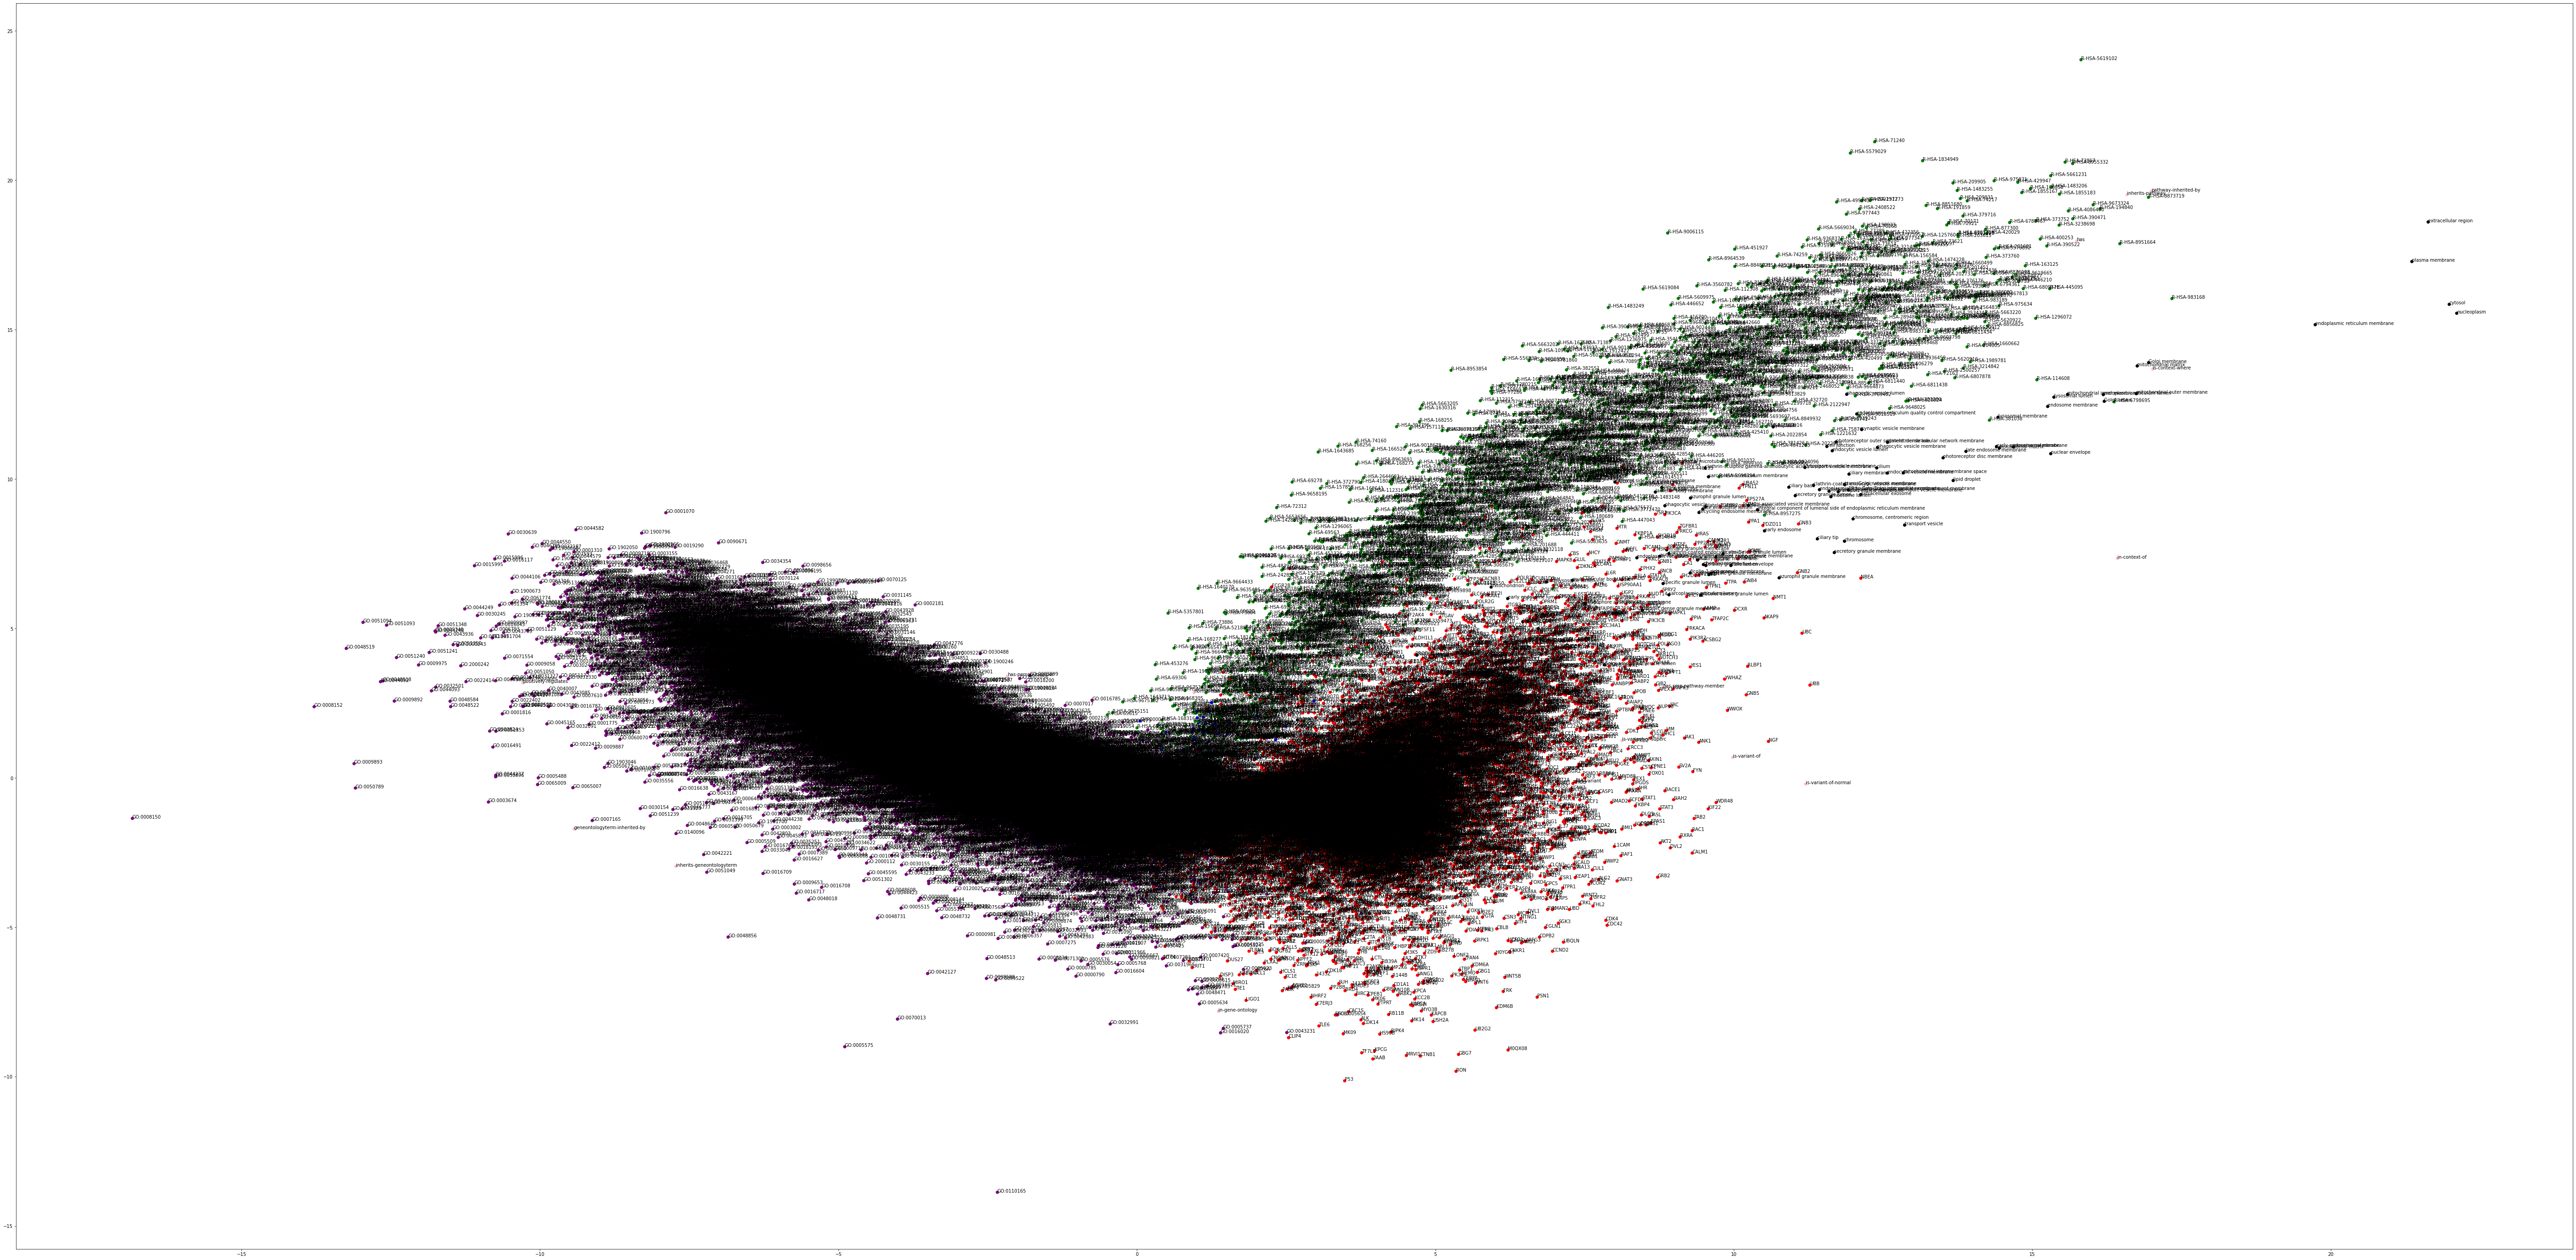

In [36]:
import matplotlib
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1],c=labels, cmap=matplotlib.colors.ListedColormap(colors))
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [37]:
model.most_similar("cytosol")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('endosome membrane', 0.7833861112594604),
 ('late endosome lumen', 0.7717321515083313),
 ('chromosome, centromeric region', 0.7708237767219543),
 ('chromosome', 0.7682913541793823),
 ('ciliary base', 0.7672224044799805),
 ('cytoplasmic vesicle membrane', 0.7670754194259644),
 ('nuclear envelope', 0.7631101608276367),
 ('extracellular exosome', 0.762419581413269),
 ('mitochondrial outer membrane', 0.7592805624008179),
 ('cilium', 0.7585927248001099)]

In [38]:
model.most_similar(positive=['superc'], negative=['normal'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('is-variant-of-superc', 0.4431113004684448),
 ('17:55343863_C/T', 0.43029606342315674),
 ('superc12', 0.4069770872592926),
 ('superc5', 0.39544495940208435),
 ('superc-has-variant', 0.3949170410633087),
 ('superc24', 0.3872814178466797),
 ('superc8', 0.3766874074935913),
 ('superc13', 0.3673774003982544),
 ('superc0', 0.367171972990036),
 ('superc6', 0.3671320378780365)]

In [39]:
model.most_similar("superc")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('superc6', 0.7015597224235535),
 ('superc17', 0.6902056336402893),
 ('superc24', 0.6784526109695435),
 ('superc21', 0.6779044270515442),
 ('superc12', 0.6773648262023926),
 ('superc23', 0.6730182766914368),
 ('superc7', 0.6682001948356628),
 ('superc13', 0.6624590158462524),
 ('superc22', 0.6610161066055298),
 ('superc2', 0.6591129899024963)]

In [40]:
#+b cell differentiation, -t cell differentiation,+ t cell proliferation
model.most_similar(positive=['GO:0030183','GO:0042098'], negative=['GO:0030217'])
#first one should be GO:0042100, b cell proliferation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0042100', 0.690528929233551),
 ('GO:0042113', 0.639100193977356),
 ('GO:0030890', 0.6152998805046082),
 ('GO:0030101', 0.6109282970428467),
 ('GO:0046651', 0.6003523468971252),
 ('GO:0042102', 0.5984771251678467),
 ('GO:0045579', 0.5866329669952393),
 ('GO:0006959', 0.5744752883911133),
 ('GO:0001923', 0.5648956298828125),
 ('GO:0050853', 0.5638020038604736)]

In [41]:
#+nucleus, +mitochondrial genome maintenence,-mitochondria
model.most_similar(positive=['GO:0005634','GO:0005739'], negative=['GO:0000002'])
#first one should be GO:0051276, nuclear genome maintenence

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0005654', 0.5772303342819214),
 ('GO:0016235', 0.5400083661079407),
 ('GO:0005737', 0.5228398442268372),
 ('GO:0005829', 0.49159371852874756),
 ('GO:0005794', 0.48360517621040344),
 ('GO:0005730', 0.4823356866836548),
 ('GO:0016607', 0.476457417011261),
 ('GO:0050821', 0.4746835231781006),
 ('GO:0008270', 0.46066564321517944),
 ('GO:0043227', 0.4604298770427704)]

In [42]:
#+nucleus, +mitochondrial genome maintenence,-mitochondria
model.most_similar(positive=['GO:0005634','GO:0000002'], negative=['GO:0005739'])
#first one should be GO:0051276, nuclear genome maintenence

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0000981', 0.5987362265586853),
 ('GO:0000790', 0.592355489730835),
 ('GO:0001228', 0.5891338586807251),
 ('GO:0000978', 0.5792145729064941),
 ('GO:0001227', 0.5641287565231323),
 ('GO:0000785', 0.5493413805961609),
 ('GO:1990841', 0.535010814666748),
 ('GO:0043565', 0.5311124920845032),
 ('GO:0001673', 0.5268588066101074),
 ('GO:0031490', 0.5206233263015747)]

In [43]:
#+nuclear transcription factor complex, +mitochondrial genome maintenence,-mitochondrian transcription
model.most_similar(positive=['GO:0044798','GO:0000002'], negative=['GO:0006390'])
#first one should be GO:0051276, nuclear genome maintenence

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0090576', 0.5231226086616516),
 ('GO:0090575', 0.5175160765647888),
 ('GO:0090578', 0.5084280967712402),
 ('GO:0090577', 0.5029326677322388),
 ('GO:0035189', 0.43514078855514526),
 ('GO:0070264', 0.43443894386291504),
 ('GO:0097221', 0.43034809827804565),
 ('GO:0072102', 0.43017148971557617),
 ('GO:0034734', 0.4278199076652527),
 ('GO:1990647', 0.42482155561447144)]

In [44]:
genemembers = {}
for sentence in phrases:
    if sentence[1]=='has-gene-ontology-member':
        if sentence[0] not in genemembers:
            genemembers[sentence[0]] = set()
        genemembers[sentence[0]].add(sentence[2])


In [45]:
gomembers = {}
for sentence in phrases:
    if sentence[1]=='geneontologyterm-inherited-by':
        if sentence[0] not in gomembers:
            gomembers[sentence[0]] = set()
        gomembers[sentence[0]].add(sentence[2])


In [46]:
import pandas as pd
infodf = pd.read_csv("csv/agingGOterms.csv")

In [47]:
aging_goterms= list(infodf["GOID"])

In [48]:
aging_goterms

['GO:0001300',
 'GO:0001301',
 'GO:0001302',
 'GO:0001303',
 'GO:0001304',
 'GO:0001305',
 'GO:0001307',
 'GO:0001308',
 'GO:0001310',
 'GO:0001311',
 'GO:0001312',
 'GO:0001313',
 'GO:0001314',
 'GO:0001316',
 'GO:0001317',
 'GO:0001318',
 'GO:0001319',
 'GO:0001320',
 'GO:0001321',
 'GO:0001322',
 'GO:0001323',
 'GO:0001324',
 'GO:0006323',
 'GO:0007568',
 'GO:0007569',
 'GO:0007580',
 'GO:0010259',
 'GO:0010978',
 'GO:0019072',
 'GO:0019073',
 'GO:0019074',
 'GO:0034652',
 'GO:0035177',
 'GO:0036385',
 'GO:0036386',
 'GO:0039631',
 'GO:0039632',
 'GO:0044815',
 'GO:0060756',
 'GO:0060757',
 'GO:0060758',
 'GO:0061434',
 'GO:0090139',
 'GO:0090342',
 'GO:0090343',
 'GO:0090344',
 'GO:0098006',
 'GO:0098035',
 'GO:0098036',
 'GO:0098037',
 'GO:1900007',
 'GO:1900008',
 'GO:1900009',
 'GO:1900062',
 'GO:1900160',
 'GO:1903368',
 'GO:1903369',
 'GO:1903370',
 'GO:1905137',
 'GO:1905138']

In [49]:
#each gene onotlogy term as measured by the genes

def compute_simularity_ratios(genemembers):
    num_first =0
    top_ten = 0
    total =0
    num_first_aging=0
    top_ten_aging=0
    total_aging=0

    for ontology_term, gene_children in genemembers.items() :
        children = list(gene_children)
        if all(gene in model.wv.vocab for gene in children):
            simlist = model.most_similar(positive=children)
            if len (simlist) >0:
                total +=1
                if ontology_term in aging_goterms:
                    total_aging +=1
                if simlist[0][0]==ontology_term:
                    num_first += 1
                    if ontology_term in aging_goterms:
                        num_first_aging +=1
                is_in_top_ten = False
                for tup in simlist:
                    if tup[0]==ontology_term:
                        is_in_top_ten = True 
                if is_in_top_ten:
                    if ontology_term in aging_goterms:
                        top_ten_aging +=1
                    top_ten += 1

                    
    ratio_in_top_ten= top_ten/total if total !=0 else 0
    ratio_first= num_first/total if total !=0 else 0
    ratio_in_top_ten_aging= top_ten_aging/total_aging if total_aging !=0 else 0
    ratio_first_aging= num_first_aging/total_aging if total_aging !=0 else 0
    return (ratio_first,ratio_in_top_ten,ratio_first_aging,ratio_in_top_ten_aging)

In [50]:
ratio_first, ratio_in_top_ten ,ratio_first_aging, ratio_in_top_ten_aging = compute_simularity_ratios(genemembers)
print ("Ratio of gene ontology terms that are closest to sum of gene children is {0}".format(ratio_first))
print ("Ratio of gene ontology terms that are top ten closest to sum of gene children is {0}".format(ratio_in_top_ten))
print ("Ratio of aging gene ontology terms that are closest to sum of gene children is {0}".format(ratio_first_aging))
print ("Ratio of aging gene ontology terms that are top ten closest to sum of gene children is {0}".format(ratio_in_top_ten_aging))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


Ratio of gene ontology terms that are closest to sum of gene children is 0.07924466517491677
Ratio of gene ontology terms that are top ten closest to sum of gene children is 0.28401462642580366
Ratio of aging gene ontology terms that are closest to sum of gene children is 0.0
Ratio of aging gene ontology terms that are top ten closest to sum of gene children is 0.2


In [51]:
#each gene onotlogy term as measured by child ontology terms
ratio_first1, ratio_in_top_ten1 ,ratio_first_aging1, ratio_in_top_ten_aging1 = compute_simularity_ratios(gomembers)
print ("Ratio of gene ontology terms that are closest to sum of gene ontology term children is {0}".format(ratio_first1))
print ("Ratio of gene ontology terms that are top ten closest to sum of gene ontology term children is {0}".format(ratio_in_top_ten1))
print ("Ratio of aging gene ontology terms that are closest to sum of gene ontology term children is {0}".format(ratio_first_aging1))
print ("Ratio of aging gene ontology terms that are top ten closest to sum of gene ontology term children is {0}".format(ratio_in_top_ten_aging1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


Ratio of gene ontology terms that are closest to sum of gene ontology term children is 0.628653261631985
Ratio of gene ontology terms that are top ten closest to sum of gene ontology term children is 0.9510170680383446
Ratio of aging gene ontology terms that are closest to sum of gene ontology term children is 0.6153846153846154
Ratio of aging gene ontology terms that are top ten closest to sum of gene ontology term children is 0.9230769230769231


In [52]:
len (model.wv.vocab)

110555

In [53]:
model.most_similar(positive=supercpersonlist)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('6:169634896_G/A', 0.8035123348236084),
 ('19:38103967_A/G', 0.7795366048812866),
 ('19:48283094_A/G', 0.7224252223968506),
 ('9:32567221_A/G', 0.7159630060195923),
 ('19:30096331_T/C', 0.7127982378005981),
 ('7:64465276_G/T', 0.6934460401535034),
 ('11:73553812_G/A', 0.6928958892822266),
 ('superc-has-variant', 0.6904358267784119),
 ('normal160', 0.6892603635787964),
 ('2:277003_A/G', 0.6878764629364014)]

In [54]:
model.most_similar("inhibits")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('is-inhibited-by', 0.948569655418396),
 ('ptmod', 0.9176034927368164),
 ('activates', 0.8861428499221802),
 ('is-ptmoded-by', 0.8806789517402649),
 ('is-activated-by', 0.8658109307289124),
 ('reacts-with', 0.8332180976867676),
 ('binds-with', 0.8137713670730591),
 ('MK14', 0.6145879626274109),
 ('DLG5', 0.6107684373855591),
 ('LATS2', 0.608231782913208)]

In [55]:
#+b cell differentiation, -t cell differentiation, + t cell proliferation
model.most_similar(positive=['GO:0030183','GO:0042098'], negative=['GO:0030217'])
#first one should be GO:0042100, b cell proliferation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0042100', 0.690528929233551),
 ('GO:0042113', 0.639100193977356),
 ('GO:0030890', 0.6152998805046082),
 ('GO:0030101', 0.6109282970428467),
 ('GO:0046651', 0.6003523468971252),
 ('GO:0042102', 0.5984771251678467),
 ('GO:0045579', 0.5866329669952393),
 ('GO:0006959', 0.5744752883911133),
 ('GO:0001923', 0.5648956298828125),
 ('GO:0050853', 0.5638020038604736)]

In [56]:
print(model.wv.word_vec('GO:0030183', use_norm=True))
print(model['GO:0030183'])

[-0.02941379 -0.13070834 -0.07402961 -0.06055719  0.09271157  0.10611179
  0.06083426  0.03544853  0.0520035  -0.10622185 -0.01244416  0.02387301
  0.07920143  0.16089183 -0.14707452  0.16314586  0.06549443  0.04981621
  0.12770301 -0.04106195  0.1440399  -0.04320842 -0.14082618 -0.10044258
  0.04485043  0.12613972 -0.00099604 -0.16283767 -0.16846529  0.18015414
  0.01441476  0.23781751  0.02200858 -0.00079207 -0.02295301  0.19754331
 -0.14434919 -0.11645839  0.06688897  0.10811022 -0.01628258 -0.03692153
  0.0157393   0.18047285  0.13013437 -0.08983207  0.06816114  0.05141713
 -0.07035682  0.06131486 -0.11902503 -0.00527798  0.06007242 -0.11765037
  0.04954613  0.08624981 -0.07284128  0.00799451 -0.09170418 -0.26944563
 -0.16571282  0.02442945 -0.06310481  0.05199331  0.04020379  0.03007851
  0.09439582 -0.17914866 -0.08166345  0.04140889 -0.10333685  0.0444366
  0.05476825 -0.08793557  0.06015151  0.07178176 -0.13771994  0.10655224
 -0.00087794 -0.02352092 -0.15728922  0.03593846 -0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [63]:
# Testing
from scipy.spatial import distance

'''
a = model['GO:0030183']
b = model['GO:0030217']
c = model['GO:0042100']
d = model['GO:0042098']

e = "is-inhibited-by"
f = "inhibits"

print(distance.euclidean(model[e], model[f]))
print(2 ** -distance.euclidean(model[e], model[f]))

from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')
print(dist.pairwise(X))
'''

s1 = "GO:0019677"
s2 = "GO:0006742"

v1 = model.wv.word_vec(s1, use_norm=True)
v2 = model.wv.word_vec(s2, use_norm=True)

print(distance.euclidean(v1, v2))
print(2 ** -distance.euclidean(v1, v2))

0.5144716501235962
0.7000492608575046


In [66]:
# Output all the GOs in the model (in form of GO-pairs) to a file named "dw_pairs.txt"
go_vocabs = []
go_pairs = []
f = open("dw_pairs.txt", "w")
for v in model.wv.vocab:
    if v.startswith("GO:"):
        go_vocabs.append(v)

i = 0
while (i + 1) < len(go_vocabs):
    f.write(go_vocabs[i] + "," + go_vocabs[i+1] + "\n")
    i = i + 2

f.close()

In [73]:
# Calculate the similarity values for the GO-pairs in "dw_pairs.txt"
from scipy.spatial import distance

f1 = open("dw_pairs.txt", "r")
lines = f1.readlines()

f2 = open("dw_results_all.txt", "w")

for line in lines:
    # print("Reading: {}".format(line))
    gos = line.split(",")
    go1 = gos[0].strip()
    go2 = gos[1].strip()
    v1 = model.wv.word_vec(go1, use_norm=True)
    v2 = model.wv.word_vec(go2, use_norm=True)
    go_similarity = 2 ** (-distance.euclidean(v1, v2))
    print("Similarity between {} and {} is {}\n".format(go1, go2, go_similarity))
    f2.write("{},{},{}\n".format(go1, go2, go_similarity))
    
'''
for line in lines:
    # print("Reading: {}".format(line))
    gos = line.split(",")
    go1 = gos[0].strip()
    go2 = gos[1].strip()
    go_similarity = model.similarity(go1, go2)
    print("Similarity between {} and {} is {}\n".format(go1, go2, go_similarity))
    f2.write("{},{},{}\n".format(go1, go2, go_similarity))
'''

f1.close()
f2.close()

Similarity between GO:0070743 and GO:0032991 is 0.42763634592877575

Similarity between GO:0005575 and GO:0031601 is 0.422232099004151

Similarity between GO:0005839 and GO:0101003 is 0.39492423884295724

Similarity between GO:0030667 and GO:0043325 is 0.41210462732976944

Similarity between GO:0071976 and GO:0048870 is 0.5425124809081702

Similarity between GO:0021915 and GO:0001228 is 0.45125260033793335

Similarity between GO:0000981 and GO:0003700 is 0.6083182984693174

Similarity between GO:0043433 and GO:0002174 is 0.4260908536188376

Similarity between GO:2000103 and GO:0008284 is 0.5350134960959753

Similarity between GO:1901724 and GO:0090184 is 0.5471900943893745

Similarity between GO:0001822 and GO:0001823 is 0.6116466256678837

Similarity between GO:0061213 and GO:2000608 is 0.6528529591721141

Similarity between GO:0061209 and GO:0061225 is 0.6395323518223297

Similarity between GO:0060987 and GO:0005737 is 0.3810534722598547

Similarity between GO:0043025 and GO:0044297 

Similarity between GO:0090367 and GO:0016556 is 0.6515381356342966

Similarity between GO:0009451 and GO:0043412 is 0.5695051987057101

Similarity between GO:0044260 and GO:0044037 is 0.4964160817489706

Similarity between GO:0003217 and GO:0003210 is 0.7961022931375488

Similarity between GO:0003259 and GO:0023019 is 0.46095260005720534

Similarity between GO:0045686 and GO:0070617 is 0.42539367821797214

Similarity between GO:0009229 and GO:0036362 is 0.3984640496686212

Similarity between GO:0018801 and GO:0044867 is 0.43686136441879675

Similarity between GO:0044866 and GO:1903015 is 0.7029423712337547

Similarity between GO:0051336 and GO:0071200 is 0.42845032882645856

Similarity between GO:0008076 and GO:0030163 is 0.35554303482191196

Similarity between GO:0042540 and GO:0006516 is 0.5473821975538298

Similarity between GO:0060977 and GO:0003169 is 0.667475197492344

Similarity between GO:0036440 and GO:0050458 is 0.615816638644452

Similarity between GO:1904224 and GO:0005942 

Similarity between GO:0014060 and GO:0033605 is 0.6205964994042347

Similarity between GO:0031166 and GO:0097637 is 0.674124942657138

Similarity between GO:0031311 and GO:0034811 is 0.4474422935600285

Similarity between GO:0102672 and GO:0008289 is 0.36798345139967165

Similarity between GO:1900131 and GO:0071257 is 0.3685602547680333

Similarity between GO:0007215 and GO:0098854 is 0.41091578418072233

Similarity between GO:0120025 and GO:0035618 is 0.5972783977039858

Similarity between GO:0010601 and GO:0016166 is 0.40392922448822327

Similarity between GO:0030393 and GO:0030668 is 0.40591629321822376

Similarity between GO:0030661 and GO:0042170 is 0.5057521454546569

Similarity between GO:0031969 and GO:0009706 is 0.8702065189105137

Similarity between GO:0009528 and GO:0033113 is 0.7116491674117909

Similarity between GO:0002663 and GO:0002514 is 0.6314252807526718

Similarity between GO:0002644 and GO:1901861 is 0.43716985570355554

Similarity between GO:1901863 and GO:1905901


Similarity between GO:1901191 and GO:1901190 is 0.6450547981460983

Similarity between GO:1901192 and GO:0001677 is 0.695595011712261

Similarity between GO:0030423 and GO:0034451 is 0.4207431618085261

Similarity between GO:0120107 and GO:0070592 is 0.4186721297823794

Similarity between GO:0070500 and GO:1901915 is 0.501176974833693

Similarity between GO:0071063 and GO:0002179 is 0.41140004677088504

Similarity between GO:0017059 and GO:0150076 is 0.44307315876002984

Similarity between GO:0150079 and GO:0046494 is 0.3743311082176881

Similarity between GO:0019289 and GO:0019540 is 0.7409696752075547

Similarity between GO:0009239 and GO:0009238 is 0.7573410777419881

Similarity between GO:0046214 and GO:0046215 is 0.7184265746138503

Similarity between GO:0009237 and GO:0032442 is 0.44553576643956083

Similarity between GO:0031588 and GO:0008603 is 0.5570909862870845

Similarity between GO:0019887 and GO:0004860 is 0.5396319368387444

Similarity between GO:0001890 and GO:0019290 i

Similarity between GO:0044558 and GO:1901079 is 0.5922146902528932

Similarity between GO:1900296 and GO:1900294 is 0.6707601818170358

Similarity between GO:0061088 and GO:0004075 is 0.35944235419716075

Similarity between GO:0016886 and GO:0086071 is 0.4084795833629228

Similarity between GO:0034113 and GO:1900426 is 0.4407113334279101

Similarity between GO:0046819 and GO:0098776 is 0.7427368640004152

Similarity between GO:0010829 and GO:0033601 is 0.35846078615517574

Similarity between GO:0060750 and GO:0003343 is 0.4173121423808207

Similarity between GO:0060485 and GO:0043149 is 0.382268003675381

Similarity between GO:0051496 and GO:0051497 is 0.5500971881933957

Similarity between GO:0051492 and GO:0033902 is 0.4021347627874128

Similarity between GO:0016892 and GO:0004521 is 0.5709976416771805

Similarity between GO:0046043 and GO:0006232 is 0.8347128918072739

Similarity between GO:0002295 and GO:0045828 is 0.4018271870843273

Similarity between GO:1900967 and GO:0004320 is

Similarity between GO:2001155 and GO:0030759 is 0.41517215768684246

Similarity between GO:0018020 and GO:0097623 is 0.3898542340191124

Similarity between GO:0070327 and GO:1905410 is 0.3365094499150898

Similarity between GO:1905411 and GO:0043833 is 0.40288355939231973

Similarity between GO:0031167 and GO:0009007 is 0.4642923410887594

Similarity between GO:2000335 and GO:2000332 is 0.8014870995029212

Similarity between GO:1901966 and GO:1901967 is 0.6886069813790238

Similarity between GO:0010648 and GO:0090273 is 0.47069072618248864

Similarity between GO:0090276 and GO:1902577 is 0.40506679262054485

Similarity between GO:0071574 and GO:0072697 is 0.6507787057714408

Similarity between GO:0031845 and GO:0031841 is 0.7918650883266087

Similarity between GO:0005119 and GO:0030437 is 0.37410015717228173

Similarity between GO:0075297 and GO:0033986 is 0.3984740589694807

Similarity between GO:0014745 and GO:0061654 is 0.366613375816031

Similarity between GO:0061723 and GO:0005980


Similarity between GO:0061948 and GO:0019262 is 0.3780947594997404

Similarity between GO:0003409 and GO:1904618 is 0.37391538152626064

Similarity between GO:0004177 and GO:0006193 is 0.3978005400341252

Similarity between GO:0006195 and GO:0033123 is 0.6318285350257068

Similarity between GO:1900544 and GO:0045981 is 0.6989122338394896

Similarity between GO:1990574 and GO:0000235 is 0.7583427966920222

Similarity between GO:0051233 and GO:0070557 is 0.39614775770366145

Similarity between GO:0035720 and GO:0032564 is 0.35870911286905033

Similarity between GO:0035374 and GO:0048385 is 0.4053106316358031

Similarity between GO:0016918 and GO:0061664 is 0.4101658526824472

Similarity between GO:0072496 and GO:1902207 is 0.41064794207595584

Similarity between GO:1902205 and GO:0006779 is 0.39703943892237215

Similarity between GO:0005826 and GO:0047440 is 0.41824209645800237

Similarity between GO:0120166 and GO:1900630 is 0.39035473392073106

Similarity between GO:0030625 and GO:000


Similarity between GO:0071393 and GO:1903914 is 0.3527981991941626

Similarity between GO:0090261 and GO:2001011 is 0.5525866317609648

Similarity between GO:0060796 and GO:0060803 is 0.6924512917956022

Similarity between GO:1904399 and GO:1905855 is 0.5760256802647001

Similarity between GO:0043402 and GO:0050774 is 0.41410953473834666

Similarity between GO:0048814 and GO:0006660 is 0.3673411925424668

Similarity between GO:0031548 and GO:0031551 is 0.677901034879355

Similarity between GO:2000544 and GO:0003944 is 0.3873375950950217

Similarity between GO:0047958 and GO:0008110 is 0.8145647868094019

Similarity between GO:2001278 and GO:2001276 is 0.629305115054985

Similarity between GO:1903248 and GO:1903250 is 0.6269226900062036

Similarity between GO:0008922 and GO:0015645 is 0.7254045923566476

Similarity between GO:0008228 and GO:0030372 is 0.38806961261266065

Similarity between GO:0005171 and GO:0015776 is 0.3753751777483639

Similarity between GO:0015774 and GO:0061891 is


Similarity between GO:1902271 and GO:0005499 is 0.7425993880183703

Similarity between GO:1903524 and GO:0045823 is 0.6179806133949368

Similarity between GO:1900030 and GO:1903954 is 0.3703991004915492

Similarity between GO:1903952 and GO:0019859 is 0.4001563853066212

Similarity between GO:0072475 and GO:0072481 is 0.8419046257444163

Similarity between GO:0072415 and GO:0050405 is 0.4058471046637342

Similarity between GO:1990616 and GO:0045016 is 0.7911714587121876

Similarity between GO:2000267 and GO:0007597 is 0.6723972584507325

Similarity between GO:1900066 and GO:1902707 is 0.452953503843681

Similarity between GO:0006277 and GO:0052827 is 0.3864252011516439

Similarity between GO:0052825 and GO:0030351 is 0.6880486273673785

Similarity between GO:0061885 and GO:0005915 is 0.3747336417123918

Similarity between GO:0044288 and GO:0098669 is 0.3835433525109124

Similarity between GO:0001324 and GO:0034370 is 0.4465832990238452

Similarity between GO:0051963 and GO:1900813 is 

Similarity between GO:0033161 and GO:0071983 is 0.4260355458970167

Similarity between GO:0071981 and GO:0030589 is 0.49590213813365974

Similarity between GO:0030588 and GO:0009561 is 0.6259499754481881

Similarity between GO:0010022 and GO:0042796 is 0.3994414373242273

Similarity between GO:0061831 and GO:0043296 is 0.5027300294855375

Similarity between GO:0006833 and GO:0002557 is 0.4489542229415862

Similarity between GO:0051793 and GO:0008658 is 0.4027384739744582

Similarity between GO:0051871 and GO:0008431 is 0.5194786573078922

Similarity between GO:0072341 and GO:0036127 is 0.5669841348697567

Similarity between GO:0051021 and GO:0051022 is 0.6179424446221422

Similarity between GO:0045525 and GO:0042235 is 0.7915228248014528

Similarity between GO:0045379 and GO:0045378 is 0.6309209557428161

Similarity between GO:0045408 and GO:0045410 is 0.5890709026265376

Similarity between GO:0099013 and GO:1990508 is 0.43264684648876667

Similarity between GO:0060414 and GO:0046622 i

Similarity between GO:0048209 and GO:0003400 is 0.6723370619883293

Similarity between GO:1905443 and GO:0000731 is 0.389106375103198

Similarity between GO:0000280 and GO:0051784 is 0.6665025081381887

Similarity between GO:0051783 and GO:1904978 is 0.516499934654202

Similarity between GO:0052199 and GO:0052204 is 0.6196724880453203

Similarity between GO:0002744 and GO:0070750 is 0.5672810286122923

Similarity between GO:0070751 and GO:0039501 is 0.45287087177292856

Similarity between GO:0102545 and GO:0052797 is 0.7978057844298079

Similarity between GO:0034711 and GO:0042839 is 0.37684338216633984

Similarity between GO:0042841 and GO:0046399 is 0.8348218401561899

Similarity between GO:0006600 and GO:0004994 is 0.39140002690017234

Similarity between GO:0036400 and GO:0008740 is 0.454790260231004

Similarity between GO:0072584 and GO:2001287 is 0.6633231337917602

Similarity between GO:0032061 and GO:0032063 is 0.8485551125557247

Similarity between GO:1904689 and GO:1990321 is 

Similarity between GO:0021886 and GO:0021979 is 0.7657007035629627

Similarity between GO:0032304 and GO:0032309 is 0.6683884140162066

Similarity between GO:0007557 and GO:1990052 is 0.4446582026137351

Similarity between GO:0070142 and GO:0060525 is 0.3656599304021559

Similarity between GO:0001784 and GO:0070521 is 0.3846729000877584

Similarity between GO:0071097 and GO:0009538 is 0.5557984539681613

Similarity between GO:0070869 and GO:1903280 is 0.3700015288293511

Similarity between GO:0005432 and GO:0052029 is 0.39143414837555035

Similarity between GO:0052003 and GO:0046721 is 0.39308178326077925

Similarity between GO:0036334 and GO:0015566 is 0.40561259527865373

Similarity between GO:0042052 and GO:1990026 is 0.4062024626242992

Similarity between GO:0019440 and GO:2001314 is 0.4377594940198816

Similarity between GO:0050691 and GO:0032006 is 0.44364249501631614

Similarity between GO:1901056 and GO:0008215 is 0.619488772316421

Similarity between GO:0006051 and GO:0047620 

Similarity between GO:0046101 and GO:0075258 is 0.3741000026136138

Similarity between GO:0008714 and GO:0045960 is 0.3901970718126261

Similarity between GO:1905455 and GO:0043769 is 0.39459341942459875

Similarity between GO:0000783 and GO:0017054 is 0.4193045137483683

Similarity between GO:0150162 and GO:0150160 is 0.6724583493413749

Similarity between GO:0120181 and GO:0120182 is 0.6609314591648572

Similarity between GO:0120183 and GO:0120180 is 0.5602516740918517

Similarity between GO:0150146 and GO:0098883 is 0.5647852808683671

Similarity between GO:0050444 and GO:0052864 is 0.3796855556670738

Similarity between GO:0001637 and GO:1905548 is 0.3613934933998381

Similarity between GO:0031509 and GO:0060039 is 0.384385540665609

Similarity between GO:0072346 and GO:0097553 is 0.5062839320845659

Similarity between GO:1903221 and GO:0072198 is 0.3793455904559869

Similarity between GO:0050567 and GO:0004040 is 0.5150864506545894

Similarity between GO:0019797 and GO:0102317 is 

Similarity between GO:0035319 and GO:0005948 is 0.4013904755509976

Similarity between GO:0034508 and GO:0036389 is 0.3923002435278616

Similarity between GO:0036387 and GO:0044687 is 0.4104283950291843

Similarity between GO:0035669 and GO:0018276 is 0.3966481762848557

Similarity between GO:0004614 and GO:0102126 is 0.3891793663017519

Similarity between GO:0018588 and GO:0050214 is 0.7216501772573066

Similarity between GO:0015344 and GO:0010745 is 0.3841423236593496

Similarity between GO:0097621 and GO:0102986 is 0.41377324295271484

Similarity between GO:0047257 and GO:0006148 is 0.3857960193771837

Similarity between GO:0005168 and GO:0090589 is 0.3542454448282557

Similarity between GO:0002087 and GO:0051947 is 0.3964804044247054

Similarity between GO:0051949 and GO:0051942 is 0.7557278591320182

Similarity between GO:0051941 and GO:1905259 is 0.42705385003519747

Similarity between GO:0008440 and GO:0044312 is 0.3756763193790117

Similarity between GO:0097736 and GO:0102813 i

Similarity between GO:0046509 and GO:1901684 is 0.4163913092599756

Similarity between GO:0048142 and GO:0007282 is 0.8503166774236213

Similarity between GO:0090483 and GO:0070901 is 0.3955057848281729

Similarity between GO:0021558 and GO:0021563 is 0.5614563865847152

Similarity between GO:0006553 and GO:1904331 is 0.4069291084658045

Similarity between GO:0032876 and GO:0106049 is 0.39478025820322055

Similarity between GO:0061662 and GO:0018496 is 0.4135906407547514

Similarity between GO:0008385 and GO:0004798 is 0.3975148372238404

Similarity between GO:2001206 and GO:0106212 is 0.3722510578331197

Similarity between GO:0103006 and GO:0035759 is 0.38644531767176216

Similarity between GO:0036040 and GO:0060792 is 0.40814472715040573

Similarity between GO:0014712 and GO:0014713 is 0.570961926552367

Similarity between GO:1990918 and GO:0047028 is 0.3905318209423644

Similarity between GO:0050280 and GO:0061758 is 0.5445322846931594

Similarity between GO:0035034 and GO:0000010 i

Similarity between GO:1905235 and GO:0036213 is 0.398820423629089

Similarity between GO:0034893 and GO:1901594 is 0.4325434357526721

Similarity between GO:0047781 and GO:0051566 is 0.5132508647727289

Similarity between GO:0045975 and GO:0031768 is 0.40891914220375514

Similarity between GO:0007313 and GO:0150034 is 0.38940440681100025

Similarity between GO:0015848 and GO:1905824 is 0.39655448398912646

Similarity between GO:0008710 and GO:0010376 is 0.4926862279741954

Similarity between GO:0009944 and GO:0050915 is 0.3921855738778333

Similarity between GO:0090574 and GO:1990512 is 0.5804966666001675

Similarity between GO:1990401 and GO:0018154 is 0.40794509128022427

Similarity between GO:0001411 and GO:0071943 is 0.4140771318459813

Similarity between GO:0070066 and GO:0060777 is 0.4160022877092022

Similarity between GO:0006017 and GO:0034524 is 0.42961843631766

Similarity between GO:1990808 and GO:0008024 is 0.42830721972928204

Similarity between GO:0070692 and GO:0032065 i

In [ ]:
# PLN vs DW similarity values comparison (Report and Plot)

import numpy as np
import matplotlib.pyplot as plt

# Read results
# f1 = open("pln_results.txt", "r")
# f2 = open("dw_results.txt", "r")
f1 = open("pln_results_all.txt", "r")
f2 = open("dw_results_all.txt", "r")
lines1 = f1.readlines()
lines2 = f2.readlines()
f1.close()
f2.close()

# Populate
gos_pos_stv = []
gos_default_stv = []
data_pln = {}
data_dw = {}
for line in lines1:
    e = line.split(",")
    p = (e[0], e[1])
    v = e[2].strip()
    if v == "NA":
        gos_default_stv.append(p)
        data_pln[p] = 0
    else:
        data_pln[p] = float(v)
        gos_pos_stv.append(p)
for line in lines2:
    e = line.split(",")
    p = (e[0], e[1])
    v = e[2].strip()
    data_dw[p] = (float(v))

# See which matches which doesn't
match_gos = []
match_data_pln = []
match_data_dw = []
no_match_gos = []
no_match_data_pln = []
no_match_data_dw = []
margin = 0.1

# for go in (gos_pos_stv + gos_default_stv):
for go_pair in gos_pos_stv:
    value_pln = data_pln.get(go_pair) if data_pln.get(go_pair) != None else data_pln.get((go_pair[1], go_pair[0]))
    value_dw = data_dw.get(go_pair) if data_dw.get(go_pair) != None else data_dw.get((go_pair[1], go_pair[0]))
    if abs(value_pln - value_dw) < margin:
        match_gos.append(go_pair[0] + "," + go_pair[1])
        match_data_pln.append(value_pln)
        match_data_dw.append(value_dw)
    else:
        no_match_gos.append(go_pair[0] + "," + go_pair[1])
        no_match_data_pln.append(value_pln)
        no_match_data_dw.append(value_dw)
    i = i + 1

print("Number of GO pairs in experiment = {}".format(len(gos_pos_stv + gos_default_stv)))
print("Number of PLN IntensionalSimilarityLinks with non-default (stv 1 0) = {}".format(len(gos_pos_stv)))
print("Number of matches for GO pairs with non-default STVs = {} ({:.2f}%)".format(len(match_gos), ((len(match_gos)/len(gos_pos_stv))*100)))

# Randomly pick n GOs to show
import random
n = 10
'''
## Randomly pick from all GOs
idx = random.sample(range(len(gos)), n)
selected_gos = [gos[i] for i in idx]
selected_pln = [data_pln[i] for i in idx]
selected_dw = [data_dw[i] for i in idx]
'''
## Randomly pick from matched GOs
idx = random.sample(range(len(match_gos)), n)
selected_gos = [match_gos[i] for i in idx]
selected_pln = [match_data_pln[i] for i in idx]
selected_dw = [match_data_dw[i] for i in idx]
'''
## Randomly pick from unmatched GOs
idx = random.sample(range(len(no_match_gos)), n)
selected_gos = [no_match_gos[i] for i in idx]
selected_pln = [no_match_data_pln[i] for i in idx]
selected_dw = [no_match_data_dw[i] for i in idx]
'''
# print(selected_gos)
# print(selected_pln)
# print(selected_dw)

# Plot
ms=5
lfs=20
plt.plot(selected_gos, selected_pln, 'go-', markersize=ms, label='PLN')
plt.plot(selected_gos, selected_dw, 'bo-', markersize=ms, label='DW')
plt.xlabel('GOs', fontsize=lfs)
plt.ylabel('Similarity', fontsize=lfs)
plt.legend(loc='best')
plt.ylim(0, 1)
plt.show()

In [75]:
sentences[1]

['GO:0031601',
 'inherits-geneontologyterm',
 'GO:0005839',
 'has-gene-ontology-member',
 'PSMA3',
 'in-smp-pathway',
 'SMP0063816',
 'has-smp-pathway-member',
 'PSMC1',
 'is-in',
 'nucleoplasm',
 'in-context-of',
 'R-HSA-8939902',
 'inherits-pathway',
 'R-HSA-8878166',
 'pathway-inherited-by',
 'R-HSA-8941333',
 'is-context-where',
 'plasma membrane',
 'has',
 'LGALS3',
 'in-gene-ontology',
 'GO:0101003',
 'inherits-geneontologyterm',
 'GO:0030667']